# Setup

## Install and load dependencies

This setup installs and loads all required packages.

In [ ]:
!pip install esda
!pip install pysal
!pip install urbanaccess 
!pip install pandana

In [ ]:
import os
import pandas as pd
import numpy as np
import esda
import pysal
import libpysal
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, clear_output
import warnings

warnings.simplefilter("ignore")

## SpaceGAN Code Base

We start with defining the *SpaceGAN* class.

In [ ]:
class SpaceGAN:
    def __init__(self, prob_config, check_config, disc_method, gen_method):
        # problem dimension
        self.latent = prob_config["noise_type"]  # noise function
        self.latent_dim = prob_config["noise_dim"]  # noise size
        self.latent_params = prob_config["noise_params"]  # noise params
        self.conditional_dim = prob_config["cond_dim"]  # conditional info
        self.output_dim = prob_config["output_dim"] # output dim
        self.output_labels = prob_config["output_labels"]
        self.input_labels = prob_config["input_labels"]

        # training
        self.epochs = prob_config["epochs"]
        self.batch_size = prob_config["batch_size"]
        self.discriminator = disc_method
        self.disc_opt = prob_config["disc_opt"](self.discriminator.parameters(), **prob_config["disc_opt_params"])
        self.generator = gen_method
        self.gen_opt = prob_config["gen_opt"](self.generator.parameters(), **prob_config["gen_opt_params"])
        self.loss = prob_config["adversarial_loss"]
        self.device = prob_config["device"]
        self.print_results = prob_config["print_results"]

        # selection
        self.check_interval = check_config["check_interval"]
        self.generate_image = check_config["generate_image"]
        self.n_samples = check_config["n_samples"]
        self.perf_metrics = check_config["perf_metrics"]
        self.perf_metrics_setting = check_config["pf_metrics_setting"]
        self.agg_funcs = check_config["agg_funcs"]
        self.agg_metrics = check_config["agg_metrics"]

        # scaling for input and output - a sklearn scaler class
        self.scaling_method_x = prob_config["scale_x"]
        self.scaling_method_y = prob_config["scale_y"]

        # plotting
        if self.print_results & self.generate_image:
            self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(12, 5))
        elif self.print_results:
            self.fig, self.ax1 = plt.subplots(1, 1, figsize=(7, 5))
        elif self.generate_image:
            self.fig, self.ax2 = plt.subplots(1, 1, figsize=(7, 5))
        else:
            self.fig = None

    def fit_scaling_method(self, x=None, y=None):
        if x is not None:
            self.scaling_method_x.fit(x)

        if y is not None:
            self.scaling_method_y.fit(y)

    def train(self, x_train, y_train, coords):
        # adversarial ground truths
        valid = torch.ones((self.batch_size, 1)).to(self.device).float()
        fake = torch.zeros((self.batch_size, 1)).to(self.device).float()
        self.df_losses = pd.DataFrame(index=range(self.epochs), columns=["D", "G"])

        # processed input and output
        self.fit_scaling_method(x_train, y_train)  # scaling procedure
        x_train = self.scaling_method_x.transform(x_train)
        y_train = self.scaling_method_y.transform(y_train)

        # tensors
        x_train = torch.from_numpy(x_train).to(self.device)
        y_train = torch.from_numpy(y_train).to(self.device)

        for epoch in range(self.epochs):
            # ------------
            # Get minibatch
            # ------------
            idx = np.random.randint(0, x_train.shape[0], self.batch_size)
            true_seq = y_train[idx]
            noise = self.latent(size=(self.batch_size, self.latent_dim), params=self.latent_params)
            noise = torch.from_numpy(noise).to(self.device)

            # ------------
            # Train Generator
            # ------------
            self.generator.zero_grad()

            # generate a batch of new data
            gen_seq = self.generator(noise, x_train[idx]).double()

            # train the generator (to have the discriminator label samples as valid)
            g_loss = self.loss(self.discriminator(gen_seq, x_train[idx]), valid)
            g_loss.backward()
            self.gen_opt.step()

            # -------------
            # Train Discriminator
            # -------------
            self.discriminator.zero_grad()

            # train the discriminator
            d_loss_real = self.loss(self.discriminator(true_seq, x_train[idx]), valid)
            d_loss_fake = self.loss(self.discriminator(gen_seq.detach(), x_train[idx]), fake)
            d_loss = 0.5 * torch.add(d_loss_real, d_loss_fake)

            d_loss.backward()
            self.disc_opt.step()

            # store losses
            self.df_losses.loc[epoch, ["D"]] = d_loss.item()
            self.df_losses.loc[epoch, ["G"]] = g_loss.item()

            # plot the progress
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, self.epochs, d_loss.item(), g_loss.item()), end="\r")

            # get images
            if self.print_results:
                self.ax1.clear()
                self.df_losses.plot(ax=self.ax1)
                self.ax1.set_xlim(0, epoch+1)

            # if at save interval => save generated output samples
            if self.check_interval is not None:
                    if epoch % self.check_interval == 0:
                        self.checkpoint_model(epoch)
                        if self.generate_image:
                            self.print_image(epoch, x_train, coords)
            if self.fig is not None:
                    clear_output(wait=True)
                    display(self.fig)

    def predict(self, x, noise=None):
        # generate noise
        x = torch.from_numpy(self.scaling_method_x.transform(x)).to(self.device)
        if noise is None:
            noise = self.latent(size=(x.shape[0], self.latent_dim), params=self.latent_params)
            noise = torch.from_numpy(noise).to(self.device)

        # generate sequence
        gen_seq = self.generator(noise, x)
        return self.scaling_method_y.inverse_transform(gen_seq.detach().cpu().numpy())

    def checkpoint_model(self, epoch):
        # generator
        torch.save(self.generator, "gen_iter %d.pkl.gz" % epoch)

        # discriminator
        torch.save(self.discriminator, "disc_iter %d.pkl.gz" % epoch)

    def print_image(self, epoch, x_train, coords):
        # generate noise
        noise = self.latent(size=(x_train.size(0), self.latent_dim), params=self.latent_params)
        noise = torch.from_numpy(noise).to(self.device)

        # generate predictions
        gen_seq = self.generator(noise, x_train)
        for _ in range(1, self.n_samples):
            # generate noise
            noise = self.latent(size=(x_train.size(0), self.latent_dim), params=self.latent_params)
            noise = torch.from_numpy(noise).to(self.device)

            # predictions
            gen_seq += self.generator(noise, x_train)
        gen_seq /= self.n_samples

        # create charts
        for (i, label) in enumerate(self.output_labels):
            # charts
            norm_gan_mean = (gen_seq[:, i] - min(gen_seq[:, i])) / (max(gen_seq[:, i]) - min(gen_seq[:, i]))
            colors = cm.rainbow(norm_gan_mean.detach().cpu().numpy())

            # plotting
            self.ax2.clear()
            for lat, long, c in zip(coords[:, 0], coords[:, 1], colors):
                self.ax2.scatter(lat, long, color=c)
            self.ax2.set_xlabel(r'$c^{(1)}$', fontsize=14)
            self.ax2.set_ylabel(r'$c^{(2)}$', fontsize=14)
            self.ax2.set_title("SpaceGAN - Epoch " + str(epoch) + " - Variable " + label)
            # self.fig.savefig(label + "_iter_" + str(epoch) + ".png", dpi = 100, transparent=True, bbox_inches="tight")

We now add some required functions for model selection; a function to retrieve the *SpaceGAN* config at a given training step and another function to compute model selection metrics.

In [ ]:
def get_spacegan_config(training_step, prob_config, check_config, cond_input, target):

    # load generator
    gen_model = torch.load("gen_iter " + str(training_step) + ".pkl.gz")

    # load discrimininator
    disc_model = torch.load("disc_iter " + str(training_step) + ".pkl.gz")

    # create a cgan object
    spacegan_i = SpaceGAN(prob_config, check_config, disc_model, gen_model)

    # get scaling method
    spacegan_i.fit_scaling_method(cond_input, target)

    return spacegan_i


def compute_metrics(target, cond_input, prob_config, check_config, coord_input, neighbours):

    # pre-allocation
    perf_metrics_dict = check_config["perf_metrics"]
    agg_funcs_dict = check_config["agg_funcs"]
    check_interval = check_config["check_interval"]
    epochs = prob_config["epochs"]
    n_samples = check_config["n_samples"]
    spacegan_iters = [x * check_interval for x in range(0, int(epochs / check_interval))] + [epochs]
    spacegan_dict = {}

    for i in spacegan_iters:
        spacegan_dict[str(i)] = get_spacegan_config(i, prob_config, check_config, cond_input, target)
        #print("Loaded checkpoint %d" % i)#, end="\r")

    # compute metrics
    # pre-allocation
    df_pred_metrics, df_agg_pred, = {}, {}
    df_pred_agg_metrics = pd.DataFrame(index=list(spacegan_dict.keys()), columns=list(perf_metrics_dict.keys()))
    for pf in list(perf_metrics_dict.keys()):
        df_pred_metrics[pf] = pd.DataFrame(index=list(range(n_samples)), columns=list(spacegan_dict.keys()))

        if pf in ["MIE", "MIEPs"]:
            # distance matrix and normalization
            dist = libpysal.cg.distance_matrix(coord_input)
            u_dist = np.unique(dist)
            k_min_dist = np.sort(u_dist.flatten())[:neighbours]
            kd = libpysal.cg.kdtree.KDTree(coord_input)
            wdist = libpysal.weights.distance.DistanceBand(kd, threshold=k_min_dist[2], binary=True, p=2)  # Queen
            wdist.transform = "r"

    for agg in list(agg_funcs_dict.keys()):
        df_agg_pred[agg] = pd.DataFrame(columns=list(spacegan_dict.keys()))

    # main loop
    for i in list(spacegan_dict.keys()):
        spacegan_predictions = np.array([])

        # sampling and performance
        for n in range(n_samples):
            if n is 0:
                spacegan_predictions = spacegan_dict[i].predict(cond_input)
            else:
                spacegan_predictions = np.concatenate([spacegan_predictions, spacegan_dict[i].predict(cond_input)], axis=1)

            # compute performance
            if check_config["sample_metrics"]:
                for pf in list(perf_metrics_dict.keys()):
                    if pf in ["MIE", "MIEPs"]:
                        df_pred_metrics[pf].loc[n, i] = perf_metrics_dict[pf](spacegan_predictions[:, n], target, wdist)
                    else:
                        df_pred_metrics[pf].loc[n, i] = perf_metrics_dict[pf](spacegan_predictions[:, n], target)

        # aggregation
        for agg in list(agg_funcs_dict.keys()):
            df_agg_pred[agg][i] = agg_funcs_dict[agg](spacegan_predictions, axis=1)
        #print("Sampled from checkpoint " + i)#, end="\r")

    # performance metrics for aggregated
    if check_config["agg_metrics"]:
        for pf in list(perf_metrics_dict.keys()):
            print("Evaluating using metric " + pf)
            for i in list(spacegan_dict.keys()):
                if pf in ["MIE", "MIEPs"]:
                    df_pred_agg_metrics.loc[i, pf] = perf_metrics_dict[pf](np.array(df_agg_pred["avg"][[i]].values, dtype="float64"), target, wdist)
                else:
                    df_pred_agg_metrics.loc[i, pf] = perf_metrics_dict[pf](np.array(df_agg_pred["avg"][[i]].values, dtype="float64"), target)
                #print("Checkpoint " + i)#, end="\r")

    # export results
    return {"sample_metrics": df_pred_metrics, "agg_metrics": df_pred_agg_metrics}


Further utilities include e.g. the functions to obtain certain metrics such as the MIE.

In [ ]:
def gaussian(size=(1, 1), **kwargs):
    if kwargs["params"] is None:
        return np.random.normal(size=size)
    else:
        noise = np.random.normal(size=size)
        if "scale" in kwargs["params"].keys():
            noise *= kwargs["params"]["scale"]
        if "loc" in kwargs["params"].keys():
            noise += kwargs["params"]["loc"]
        return noise


def rmse(obs, pred):
    return np.sqrt(np.mean(np.square(obs-pred)))


def mad(obs, pred):
    return np.mean(np.abs(obs-pred))


def pearsoncorr(obs, pred):
    return np.corrcoef(obs, pred, rowvar=False)[0, 1]


def mie(obs, pred, wdist):
    # compute Moran's Is
    np.random.seed(12345)
    local_mi = esda.moran.Moran_Local(obs, wdist, permutations=100)
    local_mi_target = local_mi.Is

    local_mi = esda.moran.Moran_Local(pred, wdist, permutations=100)
    local_mi_pred = local_mi.Is

    return np.sqrt(np.mean((local_mi_target-local_mi_pred) ** 2.0))


def moranps(obs, pred, wdist):
    # compute Moran's Is
    np.random.seed(12345)
    local_mi = esda.moran.Moran_Local(obs, wdist, permutations=500)
    local_mi_target = local_mi.p_sim

    local_mi = esda.moran.Moran_Local(pred, wdist, permutations=500)
    local_mi_pred = local_mi.p_sim

    return np.sqrt(np.mean((local_mi_target-local_mi_pred) ** 2.0))


def mase_1(obs, pred):
    return mad(obs, pred)/np.mean(np.abs(np.diff(obs, axis=0)))


def mape(obs, pred):
    return np.mean(np.abs(obs-pred)/np.abs(obs))


def smape(obs, pred):
    return np.mean(np.abs(obs - pred) / (np.abs(obs + pred) / 2.0))


def eool(obs, pred, perc):
    res = np.abs(obs - pred)
    return np.mean(res[res > np.percentile(res, perc)])


def msis_1(obs, upper, lower, alpha):
    den = np.mean(np.abs(np.diff(obs, axis=0)))
    width = np.mean(upper-lower)
    low_cov = (2.0/alpha) * np.mean((lower-obs) * (obs < lower))
    up_cov = (2.0 / alpha) * np.mean((obs - upper) * (obs > upper))
    return (width + low_cov + up_cov)/den


def get_neighbours_featurize(sp_df, spatial_coords, features, nn_size):
    # find neighbors
    from sklearn.neighbors import NearestNeighbors
    nneighbors_method = NearestNeighbors(n_neighbors=1 + nn_size).fit(sp_df[spatial_coords].values)
    nneighbors = nneighbors_method.kneighbors(X=sp_df[spatial_coords], return_distance=False)

    # labels for additional features
    label_list = []
    for out in features:
        label_list += ["nn_" + out + "_" + str(i) for i in range(nn_size)]
    aug_sp_df = pd.DataFrame(columns=label_list, index=sp_df.index)

    # get features and featurize them
    for i in sp_df.index:
        aug_sp_df.loc[i] = sp_df.iloc[nneighbors[i][1:]][features].values.reshape(-1, 1, order="F").transpose()

    return pd.concat([sp_df, aug_sp_df], axis=1), label_list

# SpaceGAN Pre-run Setup

## Dataset

We load out experimental dataset and plot it.


Text(0.5, 1.0, 'Observed')

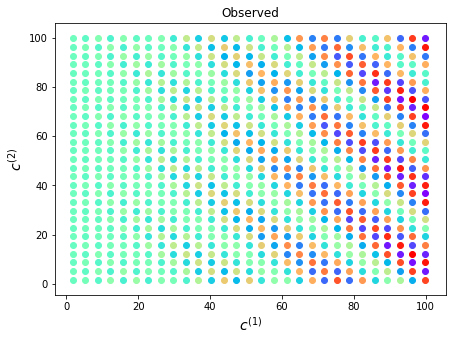

In [ ]:
%matplotlib inline

# dataset
df = pd.read_csv("https://raw.githubusercontent.com/konstantinklemmer/spacegan/master/data/toy2.csv")
coord_vars = ["longitude", "latitude"] #Define spatial coordinates
cond_vars = ["z"] + coord_vars #Define predictors
cont_vars = ["z","y"] + coord_vars #Define which neighbour features to use as context variables
output_vars = ["y"]
neighbours = 8 #Define the number of neihgbours to use

# plotting
#if ax1.collections: #Delete plot if it exists already
#  ax1.clear()
  
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
gen_seq = df[["y"]].values.astype(float)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
  ax1.scatter(lat, long, color=c)
  
ax1.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax1.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax1.set_title("Observed")


## Training config

Now, let's define the *SpaceGAN* configuration we seek to run for this problem. 

**NOTE:** If you run this using Google Colab, make sure to have your runtime set to GPU support (so `cuda` works). This can be done by clicking on "Runtime" -> "Change runtime type" and selecting "GPU" as "Hardware accelerator".

In [ ]:
# problem configuration
prob_config = {"epochs": 10000,
               "batch_size": 100,
               "device": torch.device("cuda"),
               "cond_dim": len(cond_vars) + (neighbours * len(cont_vars)),  # conditional information size
               "output_dim": len(output_vars),  # size of output
               "noise_dim": len(cond_vars) + (neighbours * len(cont_vars)),  # size of noise
               "noise_type": gaussian,  # type of noise and dimension used
               "noise_params": None,  # other params for noise (loc, scale, etc.) pass as a dict
               "scale_x": StandardScaler(),  # a sklearn.preprocessing scaling method
               "scale_y": StandardScaler(),  # a sklearn.preprocessing scaling method
               "print_results": False
               }

## Networks

We now define the Generator (G) and Discriminator (D) architecture.

In [ ]:
# Generator architecture
class Generator(nn.Module):
    def __init__(self, cond_dim, noise_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(cond_dim + noise_dim, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim)
        )

    def forward(self, z, cond_info):
        input_data = torch.cat([z, cond_info], dim=1).float()
        data = self.model(input_data).float()
        return data

# additional Generator params
prob_config["gen_opt"] = torch.optim.SGD
prob_config["gen_opt_params"] = {"lr": 0.01}

# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, output_dim, cond_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(output_dim + cond_dim, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, data, cond_info):
        input_data = torch.cat([data, cond_info], dim=1).float()
        validity = self.model(input_data).float()
        return validity
    
# additional Discriminator params
prob_config["disc_opt"] = torch.optim.SGD
prob_config["disc_opt_params"] = {"lr": 0.01}

# loss function
prob_config["adversarial_loss"] = torch.nn.BCELoss()

## Selection config

Lastly, we set the selection configuration. The `check_interval` parameter defines how often selection metrics are computed. For instance, `"check_interval": 1` would lead to metrics being computed after every training step, `"check_interval": 100` after every 100 training steps. This has an effect on the runtime of the model, particularly with more complex datasets.

In [ ]:
# checkpointing configuration
check_config = {
    "check_interval": 100,  # for model checkpointing
    "generate_image": False,
    "n_samples": 50,
    "perf_metrics": {"RMSE": rmse,
                     "MIE": mie,
                     },
    "pf_metrics_setting": {
        "RMSE": {"metric_level": "agg_metrics",
             "rank_function": np.argmin,
             "agg_function": lambda x: np.array(x)
             },
        "MIE": {"metric_level": "agg_metrics",
                "rank_function": np.argmin,
                "agg_function": lambda x: np.array(x)
               },
    },
    "agg_funcs": {"avg": np.mean,
                  "std": np.std
                 },
    "sample_metrics": False,
    "agg_metrics": True
}

# SpaceGAN - Main

## Training

Let's train our model!


In [ ]:
# neighbours
df, neighbour_list = get_neighbours_featurize(df, coord_vars, cont_vars, neighbours)

# data structures
target = df[output_vars].values
cond_input = df[cond_vars + neighbour_list].values
coord_input = df[coord_vars].values
prob_config["output_labels"] = output_vars
prob_config["input_labels"] = cond_vars + neighbour_list

# pre-instantiation
disc_method = Discriminator(prob_config["output_dim"], prob_config["cond_dim"])
disc_method.to(prob_config["device"])
gen_method = Generator(prob_config["cond_dim"], prob_config["noise_dim"], prob_config["output_dim"])
gen_method.to(prob_config["device"])

# training SpaceGAN
spacegan = SpaceGAN(prob_config, check_config, disc_method, gen_method)
spacegan.train(x_train=cond_input, y_train=target, coords=coord_input)

# export final model and data
spacegan.checkpoint_model(spacegan.epochs) 
spacegan.df_losses.to_pickle("grid_spaceganlosses.pkl.gz")

## Selection 

Now onto selection: Let's pick the best Generator (G) as determined by the *MIE* and the *RMSE* criterion.

In [ ]:
%%capture

# computing metrics
gan_metrics = compute_metrics(target, cond_input, prob_config, check_config, coord_input, neighbours)

# selecting and sampling gan
for criteria in list(check_config["perf_metrics"].keys()):
    # find best config
    criteria_info = check_config["pf_metrics_setting"][criteria]
    perf_metrics = gan_metrics[criteria_info["metric_level"]]
    perf_values = criteria_info["agg_function"](perf_metrics[[criteria]])
    best_config = perf_metrics.index[criteria_info["rank_function"](perf_values)]

    # get and set best space gan
    best_spacegan = get_spacegan_config(int(best_config), prob_config, check_config, cond_input, target)
    # training samples
    gan_samples_df = pd.DataFrame(index=range(cond_input.shape[0]), columns=cond_vars + neighbour_list + output_vars)
    gan_samples_df[cond_vars + neighbour_list] = cond_input
    gan_samples_df[output_vars] = target
    for i in range(check_config["n_samples"]):
        gan_samples_df["sample_" + str(i)] = best_spacegan.predict(gan_samples_df[cond_vars + neighbour_list])

    # export results
    gan_samples_df.to_pickle("grid_" + criteria + ".pkl.gz")
gan_metrics["agg_metrics"].to_pickle("grid_checkmetrics.pkl.gz")

Let's plot the results! First, here is how the best result for MIE selection looks:

Text(0.5, 1.0, 'SpaceGAN - Best MIE')

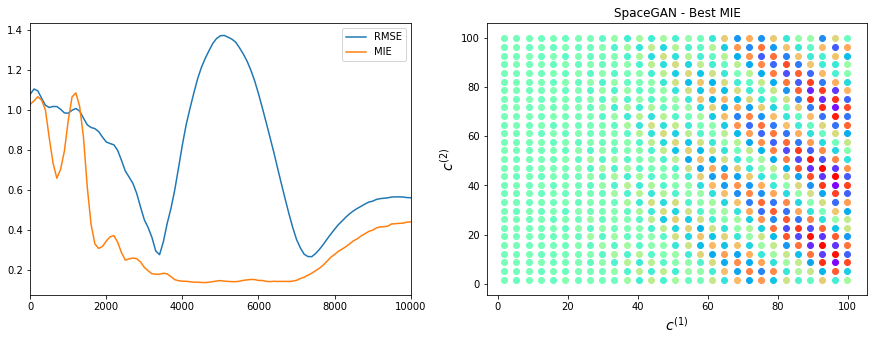

In [ ]:
%matplotlib inline

# show highlights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
gan_metrics["agg_metrics"].plot(ax=ax1)

# generate chart
gen_seq = gan_samples_df[["sample_" + str(x) for x in range(50)]].mean(axis=1)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax2.scatter(lat, long, color=c)
ax2.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax2.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax2.set_title("SpaceGAN - Best " + criteria)

Now, let's plot the best generator after *RMSE* selection:

Text(0.5, 1.0, 'SpaceGAN - Best RMSE')

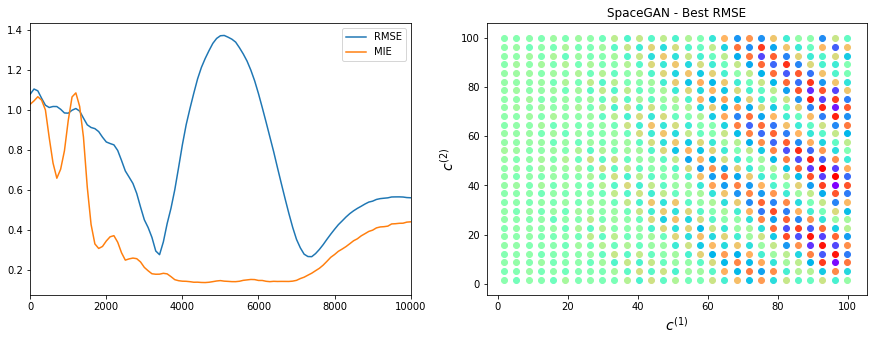

In [ ]:
%matplotlib inline

#load rmse selection results
gan_samples_df = pd.read_pickle("./grid_RMSE.pkl.gz")

# show highlights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
gan_metrics["agg_metrics"].plot(ax=ax1)

# generate chart
gen_seq = gan_samples_df[["sample_" + str(x) for x in range(50)]].mean(axis=1)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax2.scatter(lat, long, color=c)
ax2.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax2.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax2.set_title("SpaceGAN - Best RMSE")

## Selection - Pick the one you like!

If you want to see *SpaceGAN* at different stages during the training process, why not pick the model at a certain training step?

Text(0.5, 1.0, 'SpaceGAN (RMSE) - Iteration 3000')

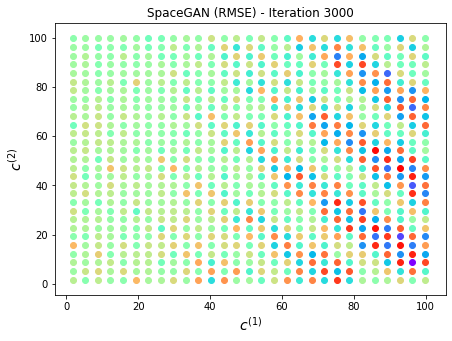

In [ ]:
iteration = 3000

# get and set best space gan
iter_spacegan = get_spacegan_config(iteration, prob_config, check_config, cond_input, target)

# training samples
gan_samples_df = pd.DataFrame(index=range(cond_input.shape[0]), columns=cond_vars + neighbour_list + output_vars)
gan_samples_df[cond_vars + neighbour_list] = cond_input
gan_samples_df[output_vars] = target
for i in range(check_config["n_samples"]):
    gan_samples_df["sample_" + str(i)] = iter_spacegan.predict(gan_samples_df[cond_vars + neighbour_list])
    
# generate chart
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
gen_seq = gan_samples_df[["sample_" + str(x) for x in range(1)]].mean(axis=1)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax1.scatter(lat, long, color=c)
ax1.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax1.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax1.set_title("SpaceGAN (RMSE) - Iteration " + str(iteration))

How does the *SpaceGAN* with *MIE* selection look after 1000 iterations?

Text(0.5, 1.0, 'SpaceGAN (MIE) - Iteration 3000')

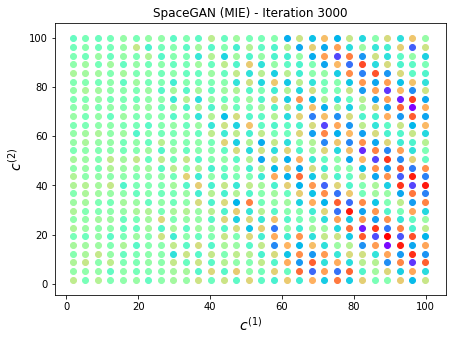

In [ ]:
iteration = 3000

# get and set best space gan
iter_spacegan = get_spacegan_config(iteration, prob_config, check_config, cond_input, target)

#load mie selection results
gan_samples_df = pd.read_pickle("./grid_MIE.pkl.gz")

# training samples
gan_samples_df = pd.DataFrame(index=range(cond_input.shape[0]), columns=cond_vars + neighbour_list + output_vars)
gan_samples_df[cond_vars + neighbour_list] = cond_input
gan_samples_df[output_vars] = target
for i in range(check_config["n_samples"]):
    gan_samples_df["sample_" + str(i)] = iter_spacegan.predict(gan_samples_df[cond_vars + neighbour_list])
    
# generate chart
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
gen_seq = gan_samples_df[["sample_" + str(x) for x in range(1)]].mean(axis=1)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax1.scatter(lat, long, color=c)
ax1.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax1.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax1.set_title("SpaceGAN (MIE) - Iteration " + str(iteration))

## Training loss vs. selection criteria

Lastly, let's see how the *SpaceGAN* training losses (for D and G) compare to our selection criteria!


Text(0.5, 1.0, 'Selection criteria during training')

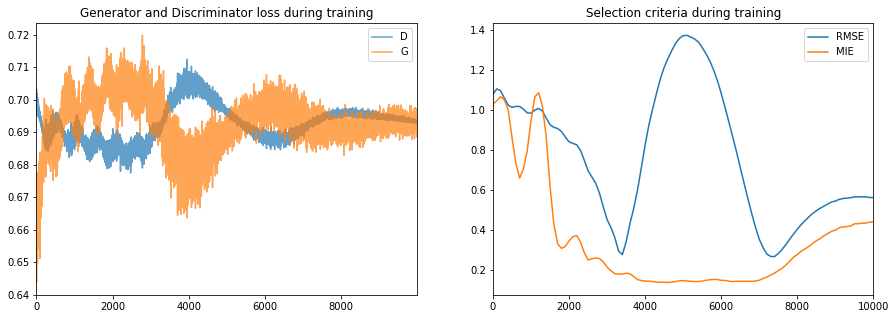

In [ ]:
%matplotlib inline

#Load loss data
loss_df = pd.read_pickle("./grid_spaceganlosses.pkl.gz")

#Plot losses and selection criteria side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

loss_df.plot(ax=ax1,alpha=0.7)
ax1.set_title("Generator and Discriminator loss during training")

gan_metrics["agg_metrics"].plot(ax=ax2)
ax2.set_title("Selection criteria during training")